# Python toolkit for fluorescence data processing

Author: Yongmin Hu (yongmin.hu@eawag.ch, yongminhu@outlook.com)

Last update: 2021-10-25

Before running the toolkit, please go through checklist_fluorescence_python_toolkit.doc.

If you change the input in any of the code blocks, please re-run all blocks after.

# 0. Import packages

In [1]:
import matplotlib
import os
import numpy as np
import matplotlib.pyplot as plt
import re

from datetime import datetime, timedelta, date
from EEMprocessing import *
from generate_widgets import *
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import Layout, Button, Dropdown, Label, FloatText, Text, IntSlider, Checkbox, Box
from IPython.display import display, clear_output
from traitlets import traitlets


matplotlib.rcParams['figure.dpi'] = 80


-------------------------------------------
# 1. Specify data directory and filename format

In [2]:
# read all filenames in the target directory
filedir_default = '_data/_greywater/20211109_grab_sample' # Just the default, could be changed 
# filedir_default = './sample_data'

# select all .dat files in the specified directory

dir_selection =ipywidgets.Text(
                               value = filedir_default,
                               description = 'File directory',
                               layout=Layout(width='100%')
                               )
ts_read_from_filename = ipywidgets.Checkbox(
                                            value = True,
                                            description = 'Do you want to read timestamps from filenames?',
                                            style={'description_width': 'initial'},
                                            layout=Layout(width='50%')
                                            )

ts_format = ipywidgets.Text(
                            value = '%Y-%m-%d-%H-%M',
                            decription = 'Format of time in the filenames',
                            layout=Layout(width='30%')
                            )
ts_start_position = ipywidgets.IntText(
                                        value = 1,
                                        decription = 'The start position of time in the filename (count from zero)',
                                        layout=Layout(width='10%')
                                        )
ts_end_position = ipywidgets.IntText(
                                        value = 16,
                                        decription = 'The start position of time in the filename (count from zero)',
                                        layout=Layout(width='10%')
                                        )

ts_widget = ipywidgets.Box([ts_format, ts_start_position, ts_end_position])
caption0 = ipywidgets.VBox([Label(value='Pleae specify the directory of fluorescence data in the text box below. Example:'),
                           Label(value='../../data/introduction/ (relative path)'),
                           Label(value='OR'),
                           Label(value='C:/Users/Alice/MasterThesis/data/introduction (absolute path)'),
                           Label(value='The directory would change automatically after entering new path.')])
caption1 = ipywidgets.Label(value='If you want to read the timestamps from the filename, please specify the time format, start and end posistions of time in the filename:')
caption2 = ipywidgets.Label(value='Time format reference: https://strftime.org/')
caption3 = ipywidgets.VBox([Label(value='Example: "2020-12-02-22-00-00_R2PEM.dat"'),
                           Label(value='Time format = %Y-%m-%d-%H-%M-%S'),
                           Label(value='start position = 1'),
                           Label(value='end position = 19')])
display(caption0, dir_selection, caption1, ts_read_from_filename, ts_widget, caption2, caption3)



Text(value='_data/_greywater/20211109_grab_sample', description='File directory', layout=Layout(width='100%'))

Label(value='If you want to read the timestamps from the filename, please specify the time format, start and e…

Checkbox(value=True, description='Do you want to read timestamps from filenames?', layout=Layout(width='50%'),…

Box(children=(Text(value='%Y-%m-%d-%H-%M', layout=Layout(width='30%')), IntText(value=1, layout=Layout(width='…

Label(value='Time format reference: https://strftime.org/')

-----------------------------------------
# 2. Data preview and parameter selection

In [3]:
%matplotlib inline

# Visualization with interaction
datdir = dir_selection.value
filelist = os.listdir(datdir)
datlist = [file for file in filelist if 'PEM.dat' in file]
data_index = []
if ts_read_from_filename.value:
    tslist = [get_TS_from_filename(file, ts_format=ts_format.value, ts_start_position=ts_start_position.value-1,
                                  ts_end_position=ts_end_position.value) for file in datlist]
    tslist_sortidx = np.argsort(tslist)
    tslist_sorted = [tslist[i] for i in tslist_sortidx]
    datlist = [datlist[i] for i in tslist_sortidx]
else:
    data_index = [file[:-4] for file in datlist]

# --------------Create widgets for plotting parameters-------------

#---------Tab1: plotting and processing step selection-------
autoscale = ipywidgets.Checkbox(value = False,
                                description='Autoscale')
inner_filter_effect = ipywidgets.Checkbox(value=True, description='Inner filter effect')
scattering_correction = ipywidgets.Checkbox(value=True,
                                            description='Scattering correction')
contour_mask = ipywidgets.Checkbox(value=False,
                                        description='Contour detection')
gaussian_smoothing = ipywidgets.Checkbox(value=True,
                                        description='Gaussian smoothing')
scattering_interpolation = ipywidgets.Dropdown(options=['zero','linear','linear2'],
                                               description='Scattering interpolation method',
                                              style={'description_width': 'initial'})
crange_cw = ipywidgets.IntRangeSlider(
    value = [0,400],
    min = 0,
    max = 1500,
    step = 100,
    description = 'Intensity',
    continuous_update=False,
    style={'description_width': 'initial'})

Em_range_display = ipywidgets.IntRangeSlider(
    value = [250,600],
    min = 200,
    max = 820,
    step = 10,
    description = 'Emission',
    continuous_update=False,
    style={'description_width': 'initial'})

Ex_range_display = ipywidgets.IntRangeSlider(
    value = [240,450],
    min = 200,
    max = 500,
    step = 5,
    description = 'Excitation',
    continuous_update=False,
    style={'description_width': 'initial'})

filedir = ipywidgets.fixed(datdir)

plot_abs = ipywidgets.Checkbox(value=True,
                               description='Plot absorbance')

filename = ipywidgets.Dropdown(options=datlist,
                               description='Filename',
                               style={'description_width': 'initial'},
                              layout={'width':'max-content'})

title = ipywidgets.Checkbox(value=False,
                           description='Figure title (time)')

ABSxmax = ipywidgets.fixed(0.1)

#----------Tab2: Parameter selection----------------

gaussian_sigma = ipywidgets.FloatText(value=1, description='gaussian smoothing sigma',
                                   style={'description_width': 'initial'})
gaussian_truncate = ipywidgets.IntText(value=3, description='gaussian smoothing truncate',
                                      style={'description_width': 'initial'})
contour_otsu = ipywidgets.Checkbox(value=True, description='OTSU automatic thresholding',
                                  style={'description_width': 'initial'})
contour_binary_threshold = ipywidgets.IntText(value=50, description='Mannual thresholding (0-255)',
                                             style={'description_width': 'initial'})
scattering_width = ipywidgets.IntText(value=15, description='Rayleigh scattering width [nm]',
                                     style={'description_width': 'initial'})
ts_format_plot = ipywidgets.fixed(value=ts_format.value)
ts_start_position_plot = ipywidgets.fixed(value=ts_start_position.value-1)
ts_end_position_plot = ipywidgets.fixed(value=ts_end_position.value)

#---------------------------Interface Layout----------------------

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between'
)

readdata_items = [
    ipywidgets.Box([filename], layout=form_item_layout),
    ipywidgets.Box([Em_range_display, Ex_range_display, crange_cw], layout=form_item_layout),
#    ipywidgets.Box([scattering_correction, scattering_interpolation],layout=form_item_layout),
    ipywidgets.Box([gaussian_smoothing, inner_filter_effect, scattering_correction],layout=form_item_layout),
    ipywidgets.Box([contour_mask, title, plot_abs],layout=form_item_layout)
]

readdata = Box(readdata_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='100%'
))

parameters_items = [
    ipywidgets.Box([gaussian_sigma, gaussian_truncate]),
    ipywidgets.Box([scattering_width, scattering_interpolation]),
    ipywidgets.Box([contour_otsu, contour_binary_threshold])
]

parameters = Box(parameters_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='solid 2px',
    align_items='stretch',
    width='100%'
))

tab = ipywidgets.Tab()
tab.children=[readdata, parameters]
tab.set_title(0, 'Read data')
tab.set_title(1, 'Parameters')


out_parameters = ipywidgets.interactive_output(plot3DEEM_interact,
                                    {'filedir':filedir, 'filename':filename, 'autoscale':autoscale,
                                     'crange':crange_cw, 'scattering_correction':scattering_correction, 'inner_filter_effect':inner_filter_effect,
                                     'plot_abs':plot_abs, 'ABSxmax':ABSxmax, 'title':title, 'Em_range_display':Em_range_display,
                                     'Ex_range_display':Ex_range_display, 'contour_mask':contour_mask, 'gaussian_smoothing':gaussian_smoothing,
                                     'scattering_interpolation': scattering_interpolation,'sigma':gaussian_sigma,'truncate':gaussian_truncate,
                                     'otsu':contour_otsu, 'binary_threshold':contour_binary_threshold, 'tolerance':scattering_width,
                                     'ts_format':ts_format_plot, 'ts_start_position':ts_start_position_plot, 'ts_end_position':ts_end_position_plot
                                                       })
note_step2 = ipywidgets.VBox([ipywidgets.Label(value="If you see blank space in the short excitation wavelength region,\
it's likely that the inner filter effect is too strong."),
                             ipywidgets.Label(value="Please consider adjust the excitation wavelength range.")])

display(tab, note_step2, out_parameters)


Output()

----------------------------------------------------
# 3. Stack data

For further analysis, the parameters would be set according to the settings in the above interface!

PLEASE CHECK THE SETTINGS before going-on!


In [15]:
#-------------------------Stack data------------------------------

stacking_interact = interactive(
                               load_EEMstack_interact,
                               {'manual':True, 'manual_name':'Stack data'},
                               filedir=ipywidgets.fixed(value=filedir.value), 
                               scattering_correction=ipywidgets.fixed(value=scattering_correction.value),
                               Em_range_display=ipywidgets.fixed(value=Em_range_display.value),
                               Ex_range_display=ipywidgets.fixed(value=Ex_range_display.value),
                               gaussian_smoothing=ipywidgets.fixed(value=gaussian_smoothing.value),
                               inner_filter_effect=ipywidgets.fixed(value=inner_filter_effect.value),
                               sigma=ipywidgets.fixed(value=gaussian_sigma.value), 
                               truncate=ipywidgets.fixed(value=gaussian_truncate.value), 
                               otsu=ipywidgets.fixed(value=contour_otsu.value), 
                               binary_threshold=ipywidgets.fixed(value=contour_binary_threshold.value), 
                               tolerance=ipywidgets.fixed(value=scattering_width.value),
                               scattering_interpolation=ipywidgets.fixed(value=scattering_interpolation.value),
                               contour_mask=ipywidgets.fixed(value=contour_mask.value), 
                               keyword_pem=ipywidgets.Text(
                                                           value='PEM.dat',
                                                           style={'description_width': 'initial'},
                                                           description='Filename searching keyword: '
                                                           ),
                               existing_datlist = ipywidgets.fixed(value=[])
                               
                               )

caption = ipywidgets.Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')
display(caption, stacking_interact)

Label(value='The stack includes all fluorescence data whose filename contains the specified keyword.')

interactive(children=(Text(value='PEM.dat', description='Filename searching keyword: ', style=DescriptionStyle…

------------------------------------------
# 4. Remove data from the data stack

Please run the code block even if you don't want to do any operation here.

Now the removal is done manually. Potential future updates would be automatic detection of abnormal data

In [16]:
#------------------Remove specific data from the data stack-----------------

EEMstack_all, Em_range_cw, Ex_range_cw, datlist_all = stacking_interact.result

datlist_filtered = datlist_all[:]
EEMstack_filtered = EEMstack_all[:,:,:]
idx2remove = []
filelist_preview = ipywidgets.Dropdown(options=datlist_all,
#                                       description='List of files',
                                       style={'description_width': 'initial'},
                                       layout={'width':'max-content'})

button_update = ipywidgets.Button(description="Remove data")

# button_reset = ipywidgets.Button(description="Reset data")

def update_filelist(*arg):
    idx2remove.append(datlist_all.index(filelist_preview.value))
    datlist_filtered.remove(filelist_preview.value)
    
button_update.on_click(update_filelist)
caption = ipywidgets.Label('This block is used to remove specific data from the data stack. Please select the data you want to remove:')
caption2 = ipywidgets.Label("To reset the data stack to its original state: re-run the block. If you don't want to make any changes here, please skip.")
display(caption, filelist_preview, button_update, caption2)


Label(value='This block is used to remove specific data from the data stack. Please select the data you want t…

Dropdown(layout=Layout(width='max-content'), options=('2021-11-09-11-51-19-B1C1S1M3R0PEM.dat', '2021-11-09-12-…

Button(description='Remove data', style=ButtonStyle())

Label(value="To reset the data stack to its original state: re-run the block. If you don't want to make any ch…

-------------------------------------
# 5. Data stack analysis

In [17]:
%matplotlib inline
#--------------------Data stack analysis---------------
pd.set_option('display.max_rows', None)

# Are there any changes in the last step?
data_index_cw = []

if datlist_filtered==datlist_all:
    datlist_cw = datlist_all[:]
    EEMstack_cw = EEMstack_all[:,:,:]
else:
    datlist_cw = datlist_filtered[:]
    EEMstack_cw = np.delete(EEMstack_filtered, idx2remove, 0)
    
if ts_read_from_filename.value:
    timestamps_cw = [get_TS_from_filename(dat, ts_format.value, ts_start_position.value-1, ts_end_position.value)
                for dat in datlist_cw ]
    timestamps_cw_sortidx = np.argsort(timestamps_cw)
    timestamps_cw = [timestamps_cw[i] for i in timestamps_cw_sortidx]
    datlist_cw = [datlist_cw[i] for i in timestamps_cw_sortidx]
    EEMstack_cw = EEMstack_cw[timestamps_cw_sortidx]
else:
    data_index_cw = [file[:-4] for file in datlist_cw]
    timestamps_cw = False

#---------------Create widgets------------------------
#----------------General widgets------------
out = ipywidgets.Output()
display(out)

button_clear_display=ipywidgets.Button(description='Clear display')
def clear_display_with_button(b):
    clear_output()
    display(tab)
button_clear_display.on_click(clear_display_with_button)

#-------Tab1: File range selection----------

Part51_widgets = Widgets51(datlist_cw)
data_range_items, range1, range2 = Part51_widgets.generate_widgets()

data_range = Box(data_range_items, layout=Layout(display='flex', 
                                                 flex_flow='column', 
                                                 border='none', 
                                                 align_items='stretch', 
                                                 width='80%'))


#-------Tab2: Pixel statistics------------------

Part52_widgets = Widgets52(EEMstack_cw, datlist_cw, range1, range2, Em_range_cw, Ex_range_cw, timestamps_cw)
pixel_statistics_items = Part52_widgets.generate_widgets()

pixel_statistics_items.append(ipywidgets.Box([button_clear_display]))
pixel_statistics = Box(pixel_statistics_items, layout=Layout(display='flex',
                                                             flex_flow='column',
                                                             border='none',
                                                             align_items='stretch',
                                                             width='100%'))

#-------Tab3: EEM statistics---------

Part53_widgets = Widgets53(EEMstack_cw, datlist_cw, range1, range2, Em_range_cw, Ex_range_cw, timestamps_cw, crange_cw)
eem_statistics_items = Part53_widgets.generate_widgets()

eem_statistics_items.append(ipywidgets.Box([button_clear_display]))

eem_statistics = Box(eem_statistics_items, layout=Layout(display='flex',
                                                         flex_flow='column',
                                                         border='none',
                                                         align_items='stretch',
                                                         width='100%'))

#-------Tab4: Region integration------------

region_integration_items = [
    ipywidgets.Box([Label(value='Under construction')]),
    ipywidgets.Box([button_clear_display], layout=form_item_layout),
]

region_integration = Box(region_integration_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='60%'
))


#-------Tab5: Stack decomposition----------

Part55_widgets = Widgets55(data_index, data_index_cw, timestamps_cw, EEMstack_cw, datlist_cw, range1, 
                         range2, Em_range_cw, Ex_range_cw)

decomposition_items = Part55_widgets.generate_widgets()

decomposition = Box(decomposition_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='100%'
))


# -------Tab6: Data reconstruction----------

Part56_widgets = Widgets56(Part55_widgets.decomposition_method_list, Part55_widgets.rank_display, crange_cw, 
                           data_index, data_index_cw, timestamps_cw, EEMstack_cw, datlist_cw, range1, 
                           range2, Em_range_cw, Ex_range_cw)
decomposition_reconstruction_items = Part56_widgets.generate_widgets()
decomposition_reconstruction_items.append(ipywidgets.Box([button_clear_display]))

decomposition_reconstruction = Box(decomposition_reconstruction_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='80%'
))

# -----------------Assembly tabs-------------------

tab = ipywidgets.Tab() 
tab.children=[data_range, pixel_statistics, eem_statistics, region_integration,
              decomposition, decomposition_reconstruction]
# tab2 = ipywidgets.Tab()
# tab2.children = [decomposition_reconstruction]
# tab.children=[data_range, pixel_statistics, eem_statistics, region_integration,
#               decomposition, tab2]
tab.set_title(0, '1. Data range selection')
tab.set_title(1, '2. Pixel statistics')
tab.set_title(2, '3. EEM statistics')
tab.set_title(3, '4. Region integraion')
tab.set_title(4, '5. Stack decomposition')
tab.set_title(5, '6. Stack reconstruction')
display(tab)

Output()

# 6. Save PARAFAC result

In [8]:
parafac_table, J_df, K_df = Part55_widgets.button_decomposition_interact.result
Part6_widgets = Widgets6(parafac_table, J_df, K_df, inner_filter_effect, scattering_correction, gaussian_smoothing, 
                         Part55_widgets.decomposition_method_list)
output_items = Part6_widgets.generate_widgets()
decomposition_output = Box(output_items, layout=Layout(
    display='flex',
    flex_flow='column',
    border='none',
    align_items='stretch',
    width='80%'
))
display(decomposition_output)

Box(children=(Box(children=(Label(value='Mandatory fields are marked with *'),)), Box(children=(Text(value='C:…

# Test

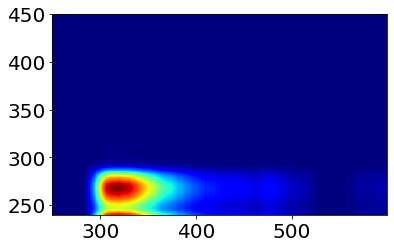

In [14]:
test = np.flipud(np.array([J_df[0]]).T).dot(np.array([K_df[0]]))
extent = [Em_range_cw.min(), Em_range_cw.max(), Ex_range_cw.min(), Ex_range_cw.max()]
plt.imshow(test, cmap='jet', extent=extent)


In [13]:
np.array([J_df[0]])

array([[2.69149071e+00, 2.26612666e+00, 1.93107029e+00, 1.82272124e+00,
        1.85726874e+00, 1.96157959e+00, 2.10291359e+00, 2.26344565e+00,
        2.45071958e+00, 2.58833907e+00, 2.72921889e+00, 2.84673834e+00,
        2.93659343e+00, 2.99144832e+00, 2.99663846e+00, 2.96412057e+00,
        2.86241889e+00, 2.67850358e+00, 2.46081105e+00, 2.29001403e+00,
        2.03355010e+00, 1.71072263e+00, 1.31963503e+00, 8.96175733e-01,
        6.27497783e-01, 3.24607520e-01, 1.55716283e-01, 7.15513961e-02,
        4.56015816e-02, 2.67269203e-02, 1.83361543e-02, 1.40878888e-02,
        1.28840296e-02, 1.22589249e-02, 1.25432975e-02, 1.31856476e-02,
        1.84894840e-02, 1.28408371e-02, 4.67761494e-03, 6.70074588e-04,
        7.08528020e-05, 1.38950672e-05, 1.49537296e-06, 1.30361029e-07,
        1.09102212e-08, 1.79656012e-09, 1.27298980e-10, 8.82236522e-12,
        6.88134540e-13, 1.20493886e-13, 1.01132840e-14, 9.22691845e-16,
        9.28249226e-17, 2.07732184e-17, 2.87634490e-18, 4.090332